# File to show all the features we extract + a first attempt at clustering

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from customColorthief import ColorThief as CT
from skimage import io
import cv2 as cv
import os

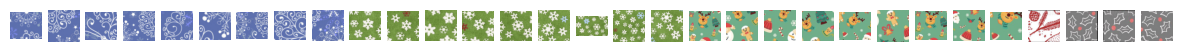

In [2]:
dirpath = './data_project/tempPieces/'
imgpaths=sorted(list(filter(lambda path: (".png" in path), [dirpath+ path for path in os.listdir(dirpath)])))

images =[Image.open(path).convert('RGB') for path in imgpaths]

fig, axes = plt.subplots(1, len(imgpaths), figsize=(15, 12))

for i, img in enumerate(images):
    axes[i].imshow(img)
    axes[i].axis("off")
    
plt.show()

## Feature 1: Hue of dominant color

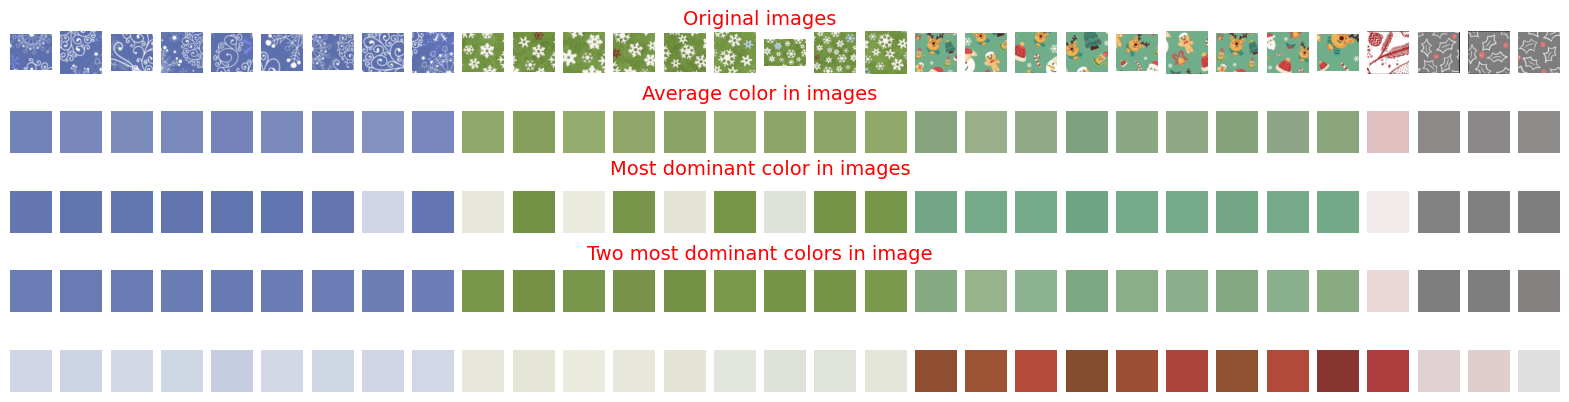

In [3]:
fig, axes = plt.subplots(5, len(imgpaths), figsize=(20, 5))

for i, image in enumerate(images):
    color_thief = CT(image)

    dominant_colors = np.array(color_thief.get_palette(quality=2, color_count=2)[0:2]).reshape(2,3)
    dominant_color = np.array(color_thief.get_color(quality=2)).reshape(1,3)
    average_color = np.uint8(np.mean(np.mean(image,axis=0), axis=0))
    
    dominant_color_img = np.tile(dominant_color, (128,128,1))
    dominant_color1_img = np.tile(dominant_colors[0], (128,128,1))
    dominant_color2_img = np.tile(dominant_colors[1], (128,128,1))
    mean_color_img = np.tile(average_color, (128,128,1))

    axes[0][i].imshow(image)
    axes[0][i].axis("off")

    axes[1][i].imshow(mean_color_img)
    axes[1][i].axis("off")

    axes[2][i].imshow(dominant_color_img)
    axes[2][i].axis("off")

    axes[3][i].imshow(dominant_color1_img)
    axes[3][i].axis("off")

    axes[4][i].imshow(dominant_color2_img)
    axes[4][i].axis("off")

plt.figtext(0.5,0.9, "Original images", ha="center", va="top", fontsize=14, color="r")
plt.figtext(0.5,0.75, "Average color in images", ha="center", va="top", fontsize=14, color="r")
plt.figtext(0.5,0.6, "Most dominant color in images", ha="center", va="top", fontsize=14, color="r")
plt.figtext(0.5,0.43, "Two most dominant colors in image", ha="center", va="top", fontsize=14, color="r")

plt.show()

## Feature 2: Gabor filter

/var/folders/w2/m4mvm5pj37107n10n7fs6sd80000gr/T/ipykernel_71685/1283461875.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  feats[k, 0] = filtered.mean()


Features of im1 are : Mean of 5.72 and std of 13.01 
Features of im2 are : Mean of 6.68 and std of 20.03 
Features of im3 are : Mean of 6.52 and std of 5.85 


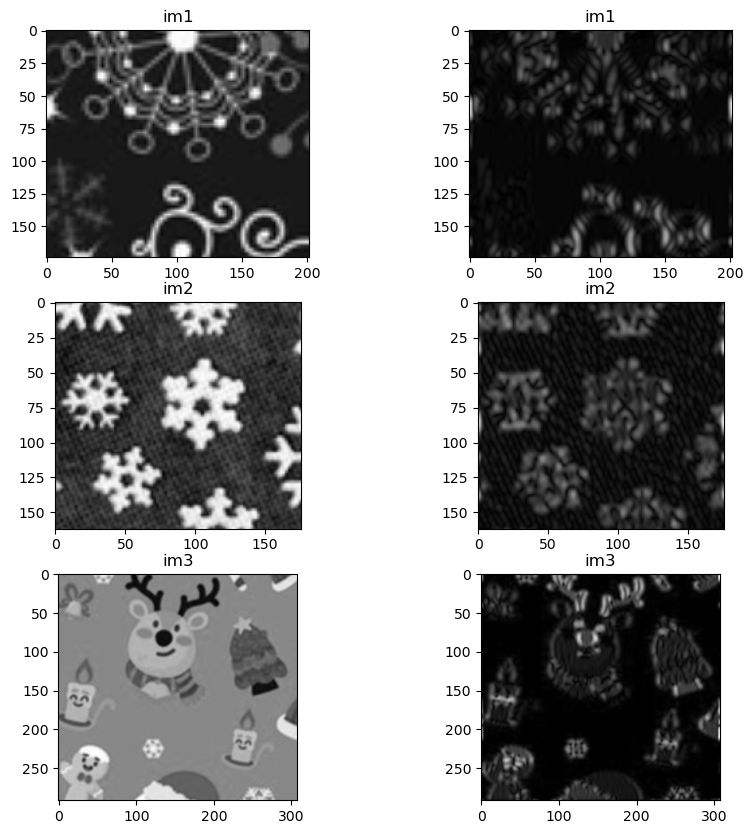

In [4]:
from skimage.filters import gabor_kernel, gabor
from scipy import ndimage as ndi

def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

def compute_feats_images(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats

# prepare filter kernel bank
sigma= 2
freq = 0.2
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    kernel = gabor_kernel(freq, theta=theta, sigma_x=sigma, sigma_y=sigma)
    kernels.append(kernel)

# prepare reference features
im1=cv.cvtColor(cv.imread(dirpath+"00_00.png"),cv.COLOR_BGR2GRAY)
im2=cv.cvtColor(cv.imread(dirpath+"01_00.png"),cv.COLOR_BGR2GRAY)
im3=cv.cvtColor(cv.imread(dirpath+"02_00.png"),cv.COLOR_BGR2GRAY)

image_names = ('im1', 'im2', 'im3')
images = (im1, im2, im3)

ref_feats = np.zeros((3, len(kernels), 2), dtype=np.double)
ref_feats[0, :, :] = compute_feats_images(im1, kernels)
ref_feats[1, :, :] = compute_feats_images(im2, kernels)
ref_feats[2, :, :] = compute_feats_images(im3, kernels)

# The result to be displayed is convoluted with kernel_nb:
kernel_nb=0
filt_images_1=power(im1,kernels[kernel_nb])
filt_images_2=power(im2,kernels[kernel_nb])
filt_images_3=power(im3,kernels[kernel_nb])

filt_images=[filt_images_1,filt_images_2,filt_images_3]

for i,nm in enumerate(image_names):
    print(f"Features of {nm} are : Mean of {ref_feats[i,kernel_nb,0]:.2f} and std of {ref_feats[i,kernel_nb,1]:.2f} ")

# Plotting:

fig, axes = plt.subplots(3,2, figsize=(10,10))

for i,row in enumerate(axes):
    row[0].imshow(images[i],cmap='gray')
    row[1].imshow(filt_images[i],cmap='gray')
    row[0].title.set_text(image_names[i])
    row[1].title.set_text(image_names[i])


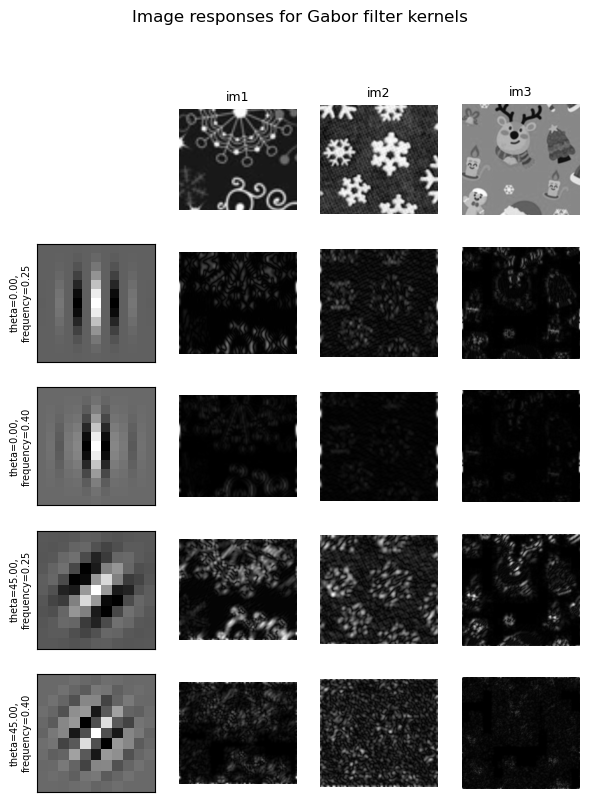

In [5]:
# Plot a selection of the filter bank kernels and their responses.
results = []
kernel_params = []
for theta in (0, 1):
    theta = theta / 4. * np.pi
    for frequency in (0.25, 0.4):
        kernel = gabor_kernel(frequency, theta=theta, sigma_x=2,sigma_y=2)
        params = f"theta={theta * 180. / np.pi:.2f},\nfrequency={frequency:.2f}"
        kernel_params.append(params)
        # Save kernel and the power image for each image
        results.append((kernel, [power(img, kernel) for img in images]))

# Plotting:
fig, axes = plt.subplots(5,4, figsize=(7, 9))
plt.gray()

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)

axes[0][0].axis('off')

# Plot original images
for label, img, ax in zip(image_names, images, axes[0][1:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=9)
    ax.axis('off')

for label, (kernel, powers), ax_row in zip(kernel_params, results, axes[1:]):
    # Plot Gabor kernel
    ax = ax_row[0]
    ax.imshow(np.real(kernel))
    ax.set_ylabel(label, fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot Gabor responses with the contrast normalized for each filter
    for patch, ax in zip(powers, ax_row[1:]):
        vmin = np.min(patch)
        vmax = np.max(patch)
        ax.imshow(patch, vmin=vmin, vmax=vmax)
        ax.axis('off')

plt.show()

## Function to get feature vector

In [6]:
from fourier import fourier_descr
from colorsys import rgb_to_hsv

'''
Function that builds a list of features for the input image.
Image should be rgb for feature extraction to work!
'''
def get_features(im):
    feature_vector = []

    color_thief = CT(im)
    dominant_colors = np.array(color_thief.get_palette(color_count = 2)[0:2]).reshape(2,3)
    for dominant_color in np.array(dominant_colors)/255:
        dominantHSV = 359*np.array(rgb_to_hsv(dominant_color[0],dominant_color[1], dominant_color[2]))
        feature_vector.extend(dominantHSV)

    im = np.array(im)
    im = cv.cvtColor(im, cv.COLOR_RGB2GRAY)

    sigma= 2
    freq = 0.2
    for theta in range(4):
        theta = theta / 4. * np.pi
        filt_real, filt_im = gabor(image=im, frequency=freq, theta=theta, sigma_x=sigma, sigma_y=sigma)
        amplitude = abs(filt_real+i*filt_im)
        feature_vector.append(amplitude.mean())
        feature_vector.append(amplitude.var())

    f_descr = fourier_descr(im, 3) # Keep the 3 first fourrier descriptors (= 6 descriptors because horizontal and vertical fft)
    feature_vector.extend(f_descr)
    return feature_vector

## Plot for different pieces using PCA

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pcas = [PCA(n_components=2),PCA(n_components=2),PCA(n_components=2)] # 3 PCAs
features = np.empty((0,20))

for path in imgpaths:
    im = Image.open(path).convert('RGB')  
    features = np.append(features, np.array(get_features(im)).reshape((1,-1)), axis=0)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

print(scaled_features.shape)
pcas[0].fit(scaled_features) #1st pca on all features
pcas[1].fit(scaled_features[:,0:6]) #2nd pca only on hsv of dominant colors
pcas[2].fit(scaled_features[:,[0,3]]) #3rd pca only on H of dominant colors
res0 = pcas[0].transform(scaled_features)
res1 = pcas[1].transform(scaled_features[:,0:6])
res2 = pcas[2].transform(scaled_features[:,[0,3]])

(31, 20)


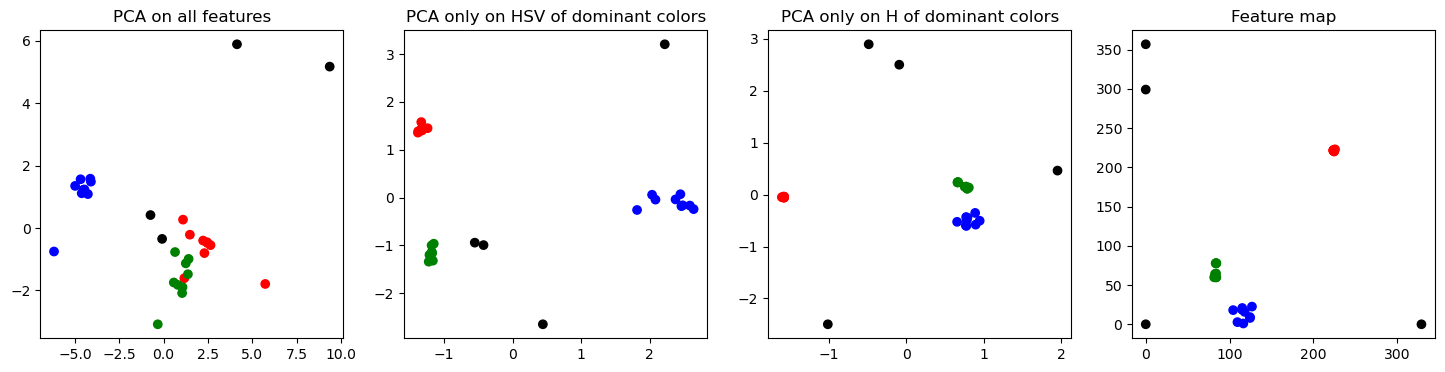

In [17]:
zeros=np.zeros(9)
ones=np.ones(9)
twos=2*ones
outliers = 3*np.ones(4)

clusters=np.uint8(np.hstack((zeros,ones,twos,outliers)))
base_colors = np.array(["red","green","blue","black"])
colors = [base_colors[clusters[i]] for i in range(len(clusters))]

fig, axes = plt.subplots(1, 4, figsize=(18, 4))

axes[0].scatter(res0[:,0], res0[:,1], c=colors)
axes[0].set_title("PCA on all features")
axes[1].scatter(res1[:,0], res1[:,1], c=colors)
axes[1].set_title("PCA only on HSV of dominant colors")
axes[2].scatter(res2[:,0], res2[:,1], c=colors)
axes[2].set_title("PCA only on H of dominant colors")
axes[3].scatter(features[:,0],features[:,3], c=colors)
axes[3].set_title("Feature map")

plt.show()

# Now trying to cluster with KMeans

In [ ]:
from sklearn.cluster import KMeans

def cluster_for_puzzle(features):
    cluster = KMeans(n_clusters=3)
    cluster.fit(features)
    labels = cluster.labels_

    occurences = [list(labels).count(i) for i in range(3)]

    while min(occurences)<=6:
        label_to_remove = [i for i, x in enumerate(occurences) if x <= 6]
        ids_to_remove = [i for i, x in enumerate(labels) if x == label_to_remove]
        features = np.delete(features, ids_to_remove, axis=0)

        cluster.fit(features)
        labels = cluster.labels_
        occurences = [list(labels).count(i) for i in range(3)]

    print(occurences)
    return cluster

In [ ]:
from sklearn.cluster import KMeans

# Either 2 or 3 puzzles -> choose 3 clusters for KMeans
cluster = cluster_for_puzzle(features)

plt.figure(1)
plt.scatter(res[:,0], res[:,1])
centers2d = pca.transform(cluster.cluster_centers_)
plt.scatter(centers2d[:,0], centers2d[:,1], marker='x')
plt.show()    

TODO: Make some way to set a minimum number of points per cluster (puzzle contains at least 9 pieces). If not, often one cluster goes to an outlier..
=> implemented, but can be better

TODO: add features to make clustering easier? -> fourier descriptors?